In [ ]:
## 1

In [ ]:
library(dplyr)
library(ggplot2)
library(coin)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
all_samples=read.table("190 samples adjacent tumor paired exon mutation_adjast_clinical.csv",sep=",",quote="\"",header=T)

In [ ]:
selected_data <- all_samples[, c("Sample", "class", "ExonicFunc.MT_ensGene","age")]

In [5]:
result <- selected_data %>%
  group_by(Sample,class,age) %>%
  summarise(
    nonsynonymous_count = sum(ExonicFunc.MT_ensGene == "nonsynonymous SNV", na.rm = TRUE),
    synonymous_count = sum(ExonicFunc.MT_ensGene == "synonymous SNV", na.rm = TRUE),
    ratio = nonsynonymous_count / synonymous_count
  )

`summarise()` has grouped output by 'Sample', 'class'. You can override using
the `.groups` argument.


In [ ]:
df_clean <- result %>%
  filter(!is.nan(ratio), !is.infinite(ratio))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.5000  0.7593  1.0000  6.0000 

In [9]:
tumor_ratio <- df_clean$ratio[df_clean$class == "tumor"]
adjacent_ratio <- df_clean$ratio[df_clean$class == "adjacent"]

In [10]:
wilcox_res <- wilcox.test(tumor_ratio, adjacent_ratio)
wilcox_res$p.value

[1] 0.2068741

In [19]:
wilcox_res <- ks.test(tumor_ratio, adjacent_ratio)
wilcox_res$p.value

[1] 0.1335557

In [ ]:
df_clean$class <- factor(df_clean$class)

perm_res <- oneway_test(ratio ~ class, data = df_clean,
                        distribution = approximate(B = 10000))
pvalue(perm_res)


Warning message in approximate(B = 10000):
“‘B’ is deprecated; use ‘nresample’ instead”


[1] 0.4837
99 percent confidence interval:
 0.4707880 0.4966276

In [ ]:
set.seed(123)

tumor_vals <- df_clean$ratio[df_clean$class == "tumor"]
adjacent_vals <- df_clean$ratio[df_clean$class == "adjacent"]

obs_diff <- mean(tumor_vals) - mean(adjacent_vals)

n_boot <- 10000
boot_diffs <- replicate(n_boot, {
  mean(sample(tumor_vals, replace = TRUE)) -
    mean(sample(adjacent_vals, replace = TRUE))
})
p_val <- mean(abs(boot_diffs) >= abs(obs_diff))

obs_diff
p_val


[1] -0.1959616

[1] 0.5462

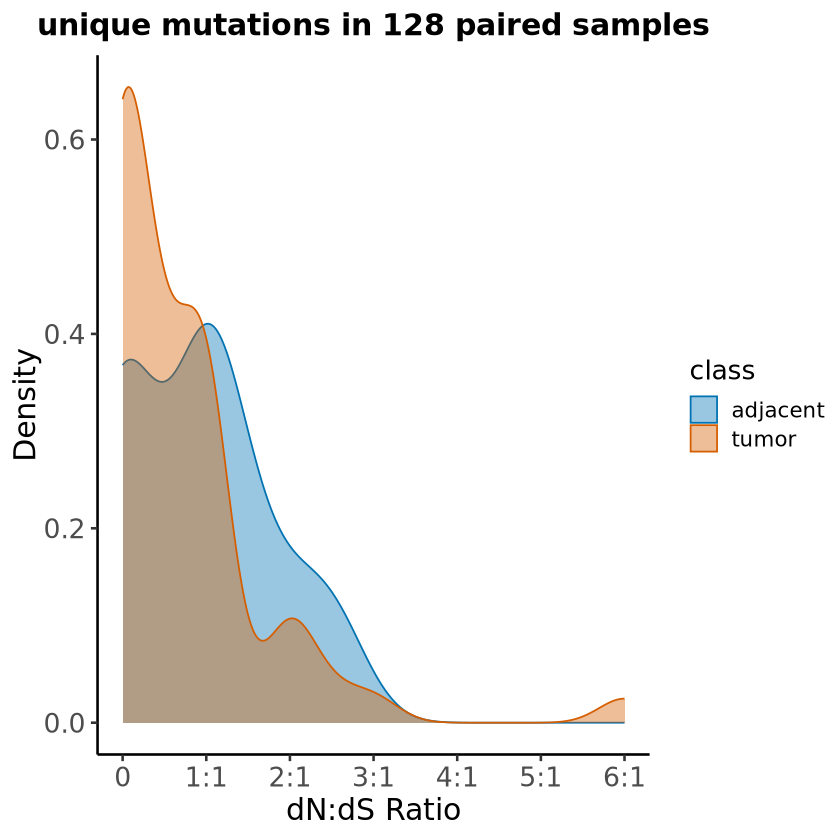

In [ ]:

p=ggplot(df_clean, aes(x = ratio, fill = class, color = class)) +
  geom_density(alpha = 0.4) +
  scale_color_manual(values = c("adjacent" = "#0072B2", "tumor" = "#D55E00")) +
  scale_fill_manual(values = c("adjacent" = "#0072B2", "tumor" = "#D55E00")) +
  scale_x_continuous(
    breaks = 0:6,  
    labels = c("0", "1:1", "2:1", "3:1", "4:1", "5:1", "6:1")
  ) +
  labs(
    title = "unique mutations in 128 paired samples",
    x = "dN:dS Ratio",
    y = "Density"
  ) +
  theme_classic(base_size = 16) + 
  theme(
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 16),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5)
  )
  print(p)

In [ ]:
## 2

In [ ]:
library(dplyr)
library(ggplot2)

In [ ]:
mutation=read.table("190 samples adjacent tumor paired exon mutation.csv",sep=",",quote = "\"",header=T)

In [ ]:
valid_genes <- mutation %>%
  filter(
    class == "tumor",
    !is.na(ExonicFunc.MT_ensGene),
    ExonicFunc.MT_ensGene != "",
    Gene.MT_ensGene != "missing"
  ) %>%
  pull(Gene.MT_ensGene) %>%
  unique()
mutation_counts <- mutation %>%
    filter(Gene.MT_ensGene %in% valid_genes) %>%
    group_by(Sample, Gene.MT_ensGene, class) %>%
    summarise(count = sum(ifelse(ExonicFunc.MT_ensGene == "", 0, 1)), .groups = 'drop')

In [ ]:
summary_stats <- mutation_counts %>%
    group_by(Gene.MT_ensGene, class) %>%
    summarise(
        avg_count = mean(count),
        ci_lower = avg_count - 1.96 * sd(count) / sqrt(n()),
        ci_upper = avg_count + 1.96 * sd(count) / sqrt(n()),
        .groups = 'drop'
    )

In [ ]:
gene_class_combinations <- expand.grid(
  Gene.MT_ensGene = unique(mutation_counts$Gene.MT_ensGene[mutation_counts$Gene.MT_ensGene != "missing"]),
  class = unique(mutation_counts$class),
  stringsAsFactors = FALSE
)

summary_stats_complete <- gene_class_combinations %>%
  left_join(summary_stats, by = c("Gene.MT_ensGene", "class"))

In [ ]:
adjacent_stats <- summary_stats_complete %>% filter(class == "adjacent")

adjacent_stats <- adjacent_stats %>%
  arrange(is.na(avg_count), desc(avg_count)) %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = Gene.MT_ensGene))

In [ ]:
adjacent_levels <- adjacent_stats$Gene.MT_ensGene %>% as.character()

tumor_stats <- summary_stats_complete %>%
  filter(class == "tumor") %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = adjacent_levels)) %>%
  arrange(Gene.MT_ensGene)

In [ ]:
color_limits <- range(c(adjacent_stats$avg_count, tumor_stats$avg_count), na.rm = TRUE)
x_limits <- c(-0.5, 4)

In [ ]:
mean_avg_count <- mean(adjacent_stats$avg_count, na.rm = TRUE)
adjacent_plot <- ggplot(adjacent_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Adjacent") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +
     scale_x_continuous(limits = x_limits) +  
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  

print(adjacent_plot)

In [ ]:
mean_avg_count <- mean(tumor_stats$avg_count, na.rm = TRUE)
tumor_plot <- ggplot(tumor_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Tumor") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +
     scale_x_continuous(limits = x_limits) +  
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  

In [ ]:
combined_plot <- (adjacent_plot | tumor_plot) +
    plot_layout(ncol = 2) +
    plot_annotation(title = "Average Number of Mutations (CI 95%)", 
                    theme = theme(plot.title = element_text(size = 22, hjust = 0.5)))
combined_plot <- combined_plot + 
    plot_annotation(tag_levels = 'A') +
    plot_layout(heights = c(1, 0)) + 
    labs(x = "Average Number of Mutations (CI 95%)")

In [ ]:
## 3

In [ ]:
library(dplyr)
library(ggplot2)

In [ ]:
mutation=read.table("190 samples adjacent tumor paired exon mutation.csv",sep=",",quote = "\"",header=T)

In [ ]:
AF=unique(mutation[,c("Sample","class","Gene.MT_ensGene","ExonicFunc.MT_ensGene","AF_value")])

In [ ]:
valid_genes <- AF %>%
  filter(
    class == "tumor",
    !is.na(ExonicFunc.MT_ensGene),
    ExonicFunc.MT_ensGene != "",
    Gene.MT_ensGene != "missing"
  ) %>%
  pull(Gene.MT_ensGene) %>%
  unique()

In [ ]:
af_means <- AF_filter %>%
filter(Gene.MT_ensGene %in% valid_genes) %>%
group_by(Sample, class, Gene.MT_ensGene) %>%
summarise(Average_AF = mean(AF_value, na.rm = TRUE), .groups = "drop")

In [ ]:
summary_stats <- af_means %>%
    group_by(Gene.MT_ensGene, class) %>%
    summarise(
        avg_count = mean(Average_AF),
        ci_lower = avg_count - 1.96 * sd(Average_AF) / sqrt(n()),
        ci_upper = avg_count + 1.96 * sd(Average_AF) / sqrt(n()),
        .groups = 'drop'
    )

In [ ]:
gene_class_combinations <- expand.grid(
  Gene.MT_ensGene = unique(af_means$Gene.MT_ensGene[af_means$Gene.MT_ensGene != "missing"]),
  class = unique(af_means$class),
  stringsAsFactors = FALSE
)

# Step 4: 合并后缺失处为 NA
summary_stats_complete <- gene_class_combinations %>%
  left_join(summary_stats, by = c("Gene.MT_ensGene", "class"))

In [ ]:
adjacent_stats <- summary_stats_complete %>%
  filter(class == "adjacent") %>%
  arrange(desc(avg_count)) %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = unique(Gene.MT_ensGene)))

In [ ]:
adjacent_levels <- adjacent_stats$Gene.MT_ensGene %>% as.character()

tumor_stats <- summary_stats_complete %>%
  filter(class == "tumor") %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = adjacent_levels)) %>%
  arrange(Gene.MT_ensGene)

In [ ]:
color_limits <- range(c(adjacent_stats$avg_count, tumor_stats$avg_count), na.rm = TRUE)
x_limits <- c(-0.4, 1.5)

In [ ]:
mean_avg_count <- mean(adjacent_stats$avg_count, na.rm = TRUE)
adjacent_plot <- ggplot(adjacent_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Adjacent") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) + 
    scale_x_continuous(limits = x_limits) +  
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  

print(adjacent_plot)

In [ ]:
mean_avg_count <- mean(tumor_stats$avg_count, na.rm = TRUE)
# 创建 tumor_plot
tumor_plot <- ggplot(tumor_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Tumor") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +  
    scale_x_continuous(limits = x_limits) +  
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  

print(tumor_plot)

In [ ]:
combined_plot <-  adjacent_plot + tumor_plot + plot_layout(ncol = 2) +
    plot_annotation(title = "Average AF Value per Sample (CI 95%)", 
                    theme = theme(plot.title = element_text(size = 22, hjust = 0.5)))

print(combined_plot)